## Abstract topic analysis 

### Inputs

- PAPERS_INFO/PROCESSED/JITS_REGULAR

### Outputs:

- topic distributions

In [51]:
import numpy as np 
import pandas as pd 
import time, re, pickle

import spacy
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
from gensim import corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# plots
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 
%matplotlib inline
from wordcloud import WordCloud

In [52]:
# read in the abstracts with journal, year information
jits = pd.read_csv('../papers_info/processed/jits_regular.csv')
jits['journal'] = 'jits'
jits = jits[['paper_id', 'year', 'cited', 'abstract', 'journal']]
papers = jits.copy()

# preprocessing the abstracts
papers['abstract_pro']  = papers['abstract'].map(lambda x: re.sub('[^\x00-\x7f]', '', x))
papers.abstract_pro = papers.abstract_pro.map(lambda x: re.sub(r'\((.*?)\)', '', x)) 
papers.abstract_pro = papers.abstract_pro.map(lambda x: x.lower())
papers.abstract_pro = papers.abstract_pro.map(lambda x: re.sub(r'[*,./:?!\'%]', '', x)) 
papers.abstract_pro = papers.abstract_pro.map(lambda x: re.sub(r'-', ' ', x)) 
papers.abstract_pro = papers.abstract_pro.map(lambda x: re.sub(r'\s+', ' ', x)) 
papers.to_csv('../papers_info/processed/papers.csv', index = False)

abstracts = papers.abstract_pro.values

print("Number of papers: JITS (%d)" % (len(jits)))

Number of papers: JITS (306), TITS(2706), TRC(2029)


In [53]:
# prepare stop words
stop_words = pd.read_csv('../utils/stop_words.txt', header=None, names = ['words']).words.values
plural_words = pd.read_csv('../utils/plural_words.txt', header=None, names=['plural', 'singular']).set_index('plural').T.to_dict('records')[0]

abs_pro = [[word if word not in plural_words else plural_words[word] for word in simple_preprocess(doc)] for doc in abstracts]
abs_pro = [[word for word in doc if word not in stop_words] for doc in abs_pro]

## Abstract analysis

In [54]:
# generate phrases
bigram = gensim.models.Phrases(abs_pro, min_count = 5, threshold = 100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
abs_pro_bis = [bigram_mod[doc] for doc in abs_pro]

trigram = gensim.models.Phrases(abs_pro_bis, threshold = 100)
trigram_mod = gensim.models.phrases.Phraser(trigram)
abs_pro_tris = [trigram_mod[doc] for doc in abs_pro_bis]

id2word = corpora.Dictionary(abs_pro_tris) #id: word
corpus = [id2word.doc2bow(text) for text in abs_pro_tris] #id: frequency

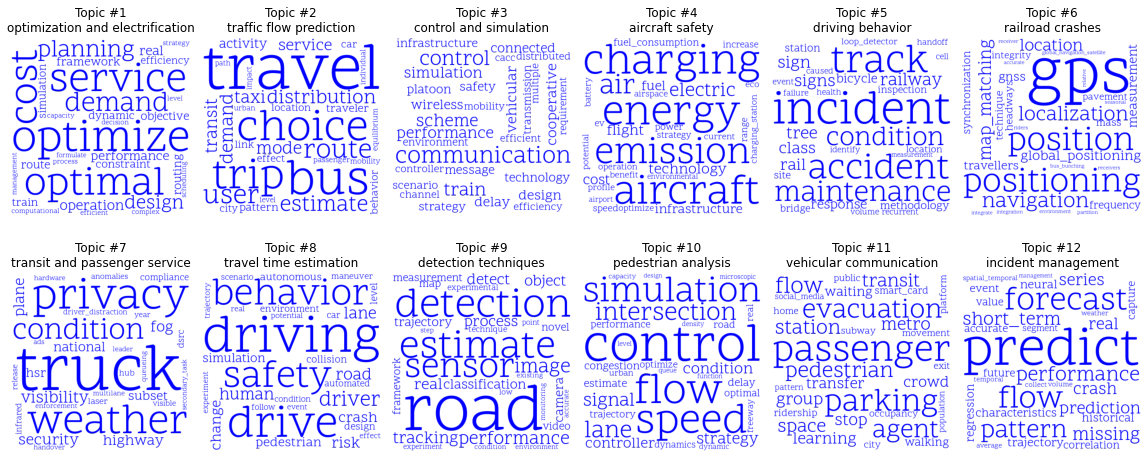

In [56]:
# lda model
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, id2word=id2word, num_topics = 12, random_state= 1042, alpha = 'asymmetric', eval_every = 1, passes = 30, chunksize = 100, per_word_topics = True, workers = 4)
#lda_model.save('topics_model_3')

# word cloud
def gen_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    return 'rgb(0, 0, 255)'

wordcloud = WordCloud(mode = 'RGBA', background_color=None, contour_color = 'steelblue', random_state = 1042, height = 400, width = 400, max_font_size=150, font_path = '../utils/ScopeOne-Regular.ttf')

f, axs = plt.subplots(nrows = 2, ncols = 6, sharex = True, sharey = True, squeeze=True, figsize = (16,7))
#topics = ['optimization and electrification', 'traffic flow prediction', 'control and simulation', 'aircraft safety', 'driving behavior', 'railroad crashes', 'transit and passenger service', 'travel time estimation', 'detection techniques', 'pedestrian analysis', 'vehicular communication', 'incident management']
d = 0
for row in range(2):
    for col in range(6):
        wordcloud.generate_from_frequencies(dict(lda_model.show_topic(d,30)))
        #wordcloud.recolor(color_func=gen_color).to_file('models/model3_topics/topic_%d.png' % d)
        axs[row][col].imshow(wordcloud.recolor(color_func=gen_color))
        axs[row][col].axis("off")
        axs[row][col].set_title('Topic #%d\n%s' % (d+1, topics[d]))
        d += 1
plt.tight_layout()
plt.show()

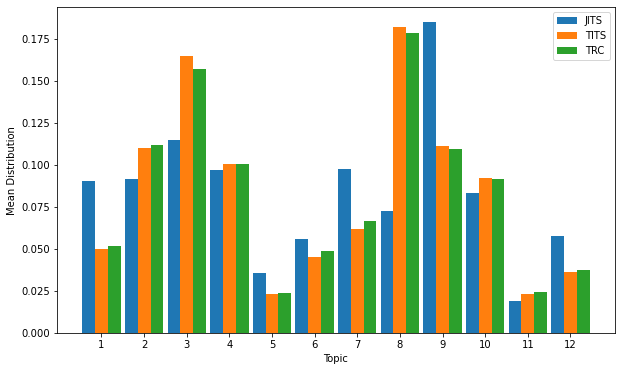

In [8]:
# jits - average topic distribution
idx_jits = papers[papers.journal == 'jits'].index.values
doc_jits = [corpus[i] for i in idx_jits]

topic_jits_dist = dict(zip(range(0, 12), np.zeros(12)))
for doc in doc_jits:
    doc_topic = lda_model.get_document_topics(doc, minimum_probability = 0.0)
    for k,v in doc_topic:
        topic_jits_dist[k] += v
topic_jits_dist = {k: v/len(doc_jits) for k, v in topic_jits_dist.items()}


plt.figure(figsize=(10,6))
plt.bar(np.arange(0, 12) - 0.3, topic_jits_dist.values(), width = 0.3, label = 'JITS')
plt.legend()
plt.xticks(range(0,12), labels=range(1,13))
plt.xlabel("Topic")
plt.ylabel("Mean Distribution")
plt.show()

In [9]:
# time
years = papers.year.unique()

topic_years = []

for year in years:
    idx = papers[papers.year == year].index.values
    docs = [corpus[i] for i in idx]

    topic_dist = dict(zip(range(0, 12), np.zeros(12)))
    for doc in docs:
        doc_topic = lda_model.get_document_topics(doc, minimum_probability = 0.0)
        for k,v in doc_topic:
            topic_dist[k] += v
    topic_dist = [(k, year, v/len(docs)) for k, v in topic_dist.items()]
    topic_years += topic_dist
topic_years = {i: [(ty[1],ty[2]) for ty in topic_years if ty[0] == i] for i in range(0,12)}

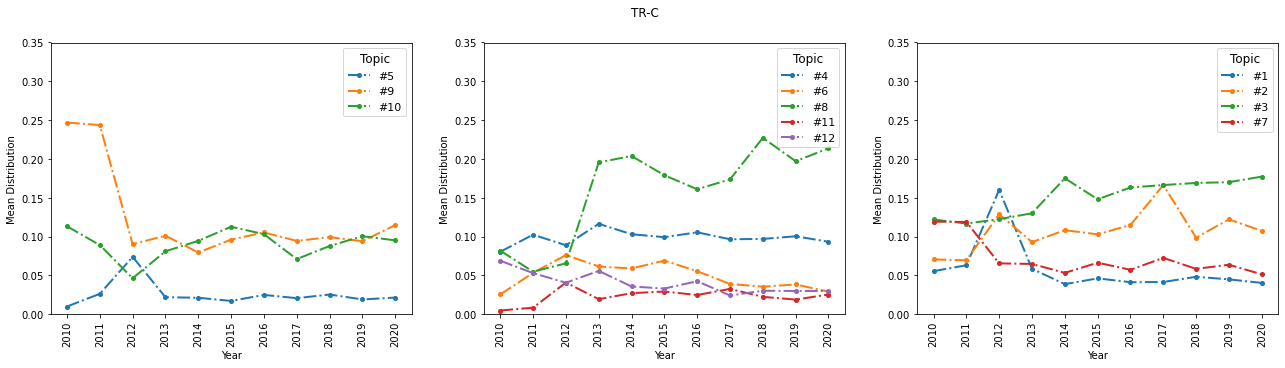

In [12]:
#year-journal

years = papers.year.unique()
topic_jits_years = []
for year in years:
    idx = papers[(papers.year == year) & (papers.journal == 'trc')].index.values
    docs = [corpus[i] for i in idx]

    topic_dist = dict(zip(range(0, 12), np.zeros(12)))
    for doc in docs:
        doc_topic = lda_model.get_document_topics(doc, minimum_probability = 0.0)
        for k,v in doc_topic:
            topic_dist[k] += v
    topic_dist = [(k, year, v/len(docs)) for k, v in topic_dist.items()]
    topic_jits_years += topic_dist
topic_jits_years = {i: [(ty[1],ty[2]) for ty in topic_jits_years if ty[0] == i] for i in range(0,12)}


plt.figure(figsize=(22,5))
plt.subplot(131)
for t, dist in topic_jits_years.items():
    if t in [4,9,8]:
        plt.plot(np.array(dist).T[0],np.array(dist).T[1], '-.o', label = '#%d'%(t+1), linewidth = 2, markersize = 4)
plt.xticks(range(2010,2021), labels=range(2010,2021), rotation = 90)
plt.xlabel('Year')
plt.ylabel('Mean Distribution')
plt.legend(loc = 'upper right', title = 'Topic', fontsize = 11, title_fontsize = 12)
plt.ylim([0, 0.35])

plt.subplot(132)
for t, dist in topic_jits_years.items():
    if t in [3,5,7,10,11]:
        plt.plot(np.array(dist).T[0],np.array(dist).T[1], '-.o', label = '#%d'%(t+1), linewidth = 2, markersize = 4)
plt.xticks(range(2010,2021), labels=range(2010,2021), rotation = 90)
plt.xlabel('Year')
plt.ylabel('Mean Distribution')
plt.legend(loc = 'upper right', title = 'Topic', fontsize = 11, title_fontsize = 12)
plt.ylim([0, 0.35])


plt.subplot(133)
for t, dist in topic_jits_years.items():
    if t in [0,1,2,6]:
        plt.plot(np.array(dist).T[0],np.array(dist).T[1], '-.o', label = '#%d'%(t+1), linewidth = 2, markersize = 4)
plt.xticks(range(2010,2021), labels=range(2010,2021), rotation = 90)
plt.xlabel('Year')
plt.ylabel('Mean Distribution')
plt.legend(loc = 'upper right', title = 'Topic', fontsize = 11, title_fontsize = 12)
plt.ylim([0, 0.35])

plt.suptitle('J-ITS')
plt.show()